# Function for Cluster Plot
## Example Parameter: Avg Leaf Nitrogen Concentration (LNC) vs Leaf Carbon Nitrogen Ratio (LCN)
#### Author: Sofia Ingersoll

##### Loading environment settings

In [2]:
# moved the libraries that were here into utils.py because they're essential
# xarray is required to run the utils import line
import xarray as xr

Calling the machine learning utils.py `ml_utils.py` located in this ML folder

In [3]:
# import libraries & data pre-processing functions from utils.py
from ml_utils import *

##### Request additional processing power from server

In [4]:
# Request an additional 10 cores of power for processing from the server
client = get_cluster("UCSB0021", cores = 40)

In [5]:
# apply peer2peer network communication across multiple devices
client.cluster

PBSCluster(848aa4e7, 'tcp://128.117.208.54:40931', workers=40, threads=40, memory=372.40 GiB)

## Function to plot variable cluster vs parameter file

#### Function for user selected variable & parameter subsetting, wrangling, & plotting
Here we can see greater definition regarding the shape of the points. There seems to be less of a linear relationship than the one observed above. However, the x-axis is not wihtin hte same bounds and this is concerning.

Also, need to create a list of nicely written parameter and variable names to call from for an f str in the x & y labels.

In [6]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----     load data stored in casper     ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#------- Parameter Data---------
# x variable data for plotting
df = pd.read_csv('/glade/campaign/asp/djk2120/PPEn11/csvs/lhc220926.txt',index_col=0)
# the only dimension here is the 'member' aka file index id [LCH0001-500]
# convert to data set
params = xr.Dataset(df)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----    User Selected Plotting Funct    ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def subset_and_plot_cluster(param, var):
    '''describe the relationship between the selected variable 
    and parameter(s) between 2005-2010. output a
    cluster plot averaged by year.'''

    # Read in and wrangle user selected parameter cluster
    param_avg  = params[param]

    
    # Read in and wrangle user selected variable cluster
    da_v = read_all_simulations(var)
    # feb. ncar time bug
    da = fix_time(da_v)
    # convert xr.ds to xr.da
    da = da[var]
    # weight gridcell dim by global land area
    da_global = weight_landarea_gridcells(da, landarea)
    # weight time dim by days in month
    da_global_ann = yearly_weighted_average(da_global)
    # take global avg for variable over year dimension
    var_avg = da_global_ann.mean(dim='year')


    # Plotting
    plt.scatter(y=var_avg, color = '#62c900ff', alpha = 0.8)
    # Set plot labels and title
    plt.xlabel(param)
    plt.ylabel(var)
    plt.title('2005-2010 Global Average')
    # Show the plot
    plt.show()

In [7]:
params

<xarray.Dataset>
Dimensions:              (member: 500)
Coordinates:
  * member               (member) object 'LHC0001' 'LHC0002' ... 'LHC0500'
Data variables: (12/32)
    FUN_fracfixers       (member) float64 0.7783 0.3193 0.8768 ... 0.2621 0.4221
    KCN                  (member) float64 0.358 0.5488 0.2108 ... 0.9123 0.8392
    a_fix                (member) float64 0.255 0.6302 0.6621 ... 0.5339 0.1443
    crit_dayl            (member) float64 0.4012 0.27 0.3534 ... 0.9974 0.6571
    d_max                (member) float64 0.7978 0.5361 0.1409 ... 0.9076 0.4009
    fff                  (member) float64 0.1301 0.6792 ... 0.9918 0.02798
    ...                   ...
    stem_leaf            (member) float64 0.1138 0.1273 0.25 ... 0.3328 0.347
    sucsat_sf            (member) float64 0.7982 0.3947 0.1681 ... 0.3526 0.6515
    theta_cj             (member) float64 0.03646 0.09374 ... 0.8429 0.5055
    tpu25ratio           (member) float64 0.3936 0.04108 0.8197 ... 0.716 0.2124
    tpuse_sf             (member) float64 0.07896 0.2756 0.8401 ... 0.353 0.3634
    wc2wjb0              (member) float64 0.6846 0.8785 0.9519 ... 0.3581 0.1567

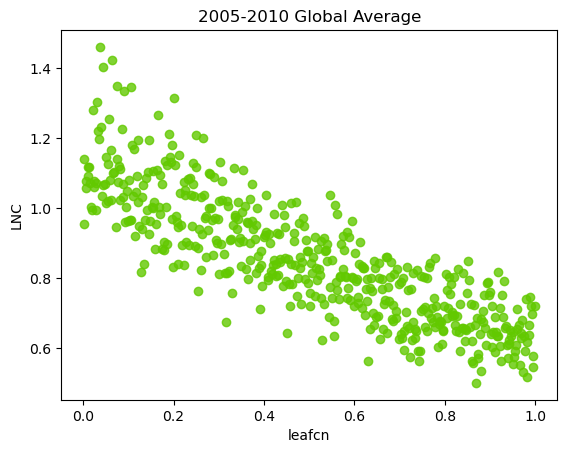

In [29]:
# Example usage:
subset_and_plot_cluster('leafcn', 'LNC')

## Walking through the process

### Loading a Cluster of 500 files
The data files are located in `/glade/campaign/cgd/tss/projects/PPE/PPEn11_LHC/transient/hist/`

The 2005-2010 monthly output files have the form:
`PPEn11_transient_LHC0001.clm2.h0.2005-02-01-00000.nc`

We're interested in files spanning from:
`LHC0001 to LHC0500`

In [6]:
# read in variable cluster
da = read_all_simulations('LNC')

In [ ]:
# subset in parameter file
leafcn = params['leafcn']

### Wrangling Cluster for Global Avg with properly weighted dimensions (time & gridcell) 

#### Applying data processing functions from utils

In [7]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----    variable wrangling     ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# apply the bug fixing & dim. reduction functions 

# feb. ncar time bug
da = fix_time(da)

# convert xr.ds to xr.da
da = da['LNC']

# weight gridcell dim by global land area
da_global = weight_landarea_gridcells(da,landarea)

# weight time dim by days in month
da_global_ann = yearly_weighted_average(da_global)

# take global avg for param over year dimension
lnc = da_global_ann.mean(dim='year')

In [8]:
lnc

<xarray.DataArray (ens: 500)>
dask.array<mean_agg-aggregate, shape=(500,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Dimensions without coordinates: ens

### Visualize Cluster Plot with Linear Regression
I confirmed that the leafcn data provided and LNC are the same length, but it's not running. I am going to create a data array from the cluster files read in 

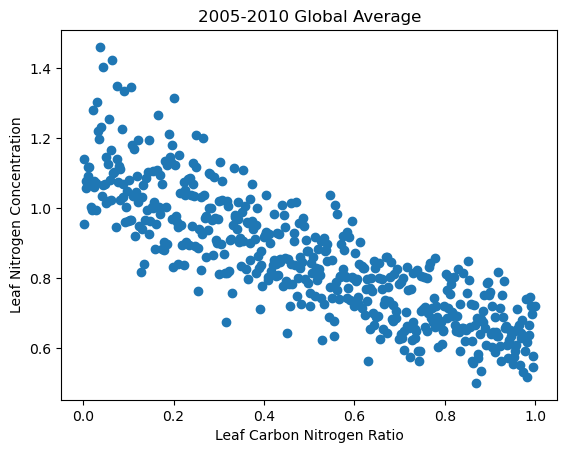

In [9]:
plt.scatter(x = leafcn,
            y = lnc)

# Set plot labels and title
plt.xlabel('Leaf Carbon Nitrogen Ratio')
plt.ylabel('Leaf Nitrogen Concentration')
plt.title('2005-2010 Global Average')

# Show the plot
plt.show()

## Linear Regression


In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----      Split Data 90/10        ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
x_train, x_test, y_train, y_test = train_test_split(leafcn, 
                                                    lnc, 
                                                    test_size = 0.20,
                                                    random_state=0)

In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----      Linear Regression       ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
regressor = LinearRegression()
regressor.fit(leafcn, lnc)

In [ ]:
# Assuming leafcn_da and LNC_da are your pre-processed data arrays
# Make sure that leafcn_da and LNC_da have the same length and are 1D arrays
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----      Split Data 90/10        ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
x_train, x_test, y_train, y_test = train_test_split(leafcn, lnc, test_size=0.1, random_state=0)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----      Linear Regression       ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
regressor = LinearRegression()
regressor.fit(x_train, y_train)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----       Make Predictions       ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
y_pred = regressor.predict(x_test)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----    Plot Linear Regression    ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
plt.scatter(x_train, y_train, color='g', label='Training Data')
plt.scatter(x_test, y_test_, color='b', label='Testing Data')
plt.plot(x_test, y_pred, color='k', linewidth=2, label='Linear Regression')

plt.xlabel('Leaf Carbon Nitrogen Ratio')
plt.ylabel('Leaf Nitrogen Concentration')
plt.title("Linear Regression of f{'var'} vs f{'param'}")
plt.legend()
plt.show()